In [11]:
from IPython.display import HTML
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

In [2]:
import pandas as pd
import networkx as nx
import community
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import numpy as np
from collections import defaultdict
from sklearn.neighbors import BallTree
import gc
%matplotlib inline

columns = ["pubId", "is_hourly", "seqId", "on_homepage", "canonicalUrl",
                   "firstScrape", "lang_iso", "lang_reliability", "title", "text"]

def read_article_df(file):
    articles_dt = file.read().split('\n')[:-1]
    pubId, canonicalUrl,firstScrape,title,text,lang_reliability = [],[],[],[],[],[]
    lang_iso = []
    for article in articles_dt:    
        row = article.split('\t')
        pubId.append(row[0])
        canonicalUrl.append(row[4])
        firstScrape.append(row[5])
        lang_iso.append(row[6])
        lang_reliability.append(row[7])
        title.append(row[8])
        text.append(row[9])

    articles_df = pd.DataFrame()
    articles_df['pubId'] = pubId
    articles_df['canonicalUrl'] = canonicalUrl
    articles_df['firstScrape'] = firstScrape
    articles_df['title'] = title
    articles_df['text'] = text
    articles_df['lang_reliability'] = lang_reliability
    articles_df['lang_iso'] = lang_iso
    return articles_df

emb_df = pd.read_csv('../data/embedding/Doc2Vec_embedding_output.csv',index_col=0)

article_df = read_article_df(open('../data/raw/2018_07_19_04_59_08/articles.txt', encoding='utf-8'))
article_df = article_df[article_df.lang_reliability == '1'].reset_index(drop=True)

article_df['title'] = article_df.title.apply(lambda s: s.strip())
article_df['text'] = article_df.text.apply(lambda s: s.strip())
article_df['title_len'] = article_df.title.apply(len)
article_df['text_len'] = article_df.text.apply(len)

clean_df = article_df[article_df.title_len > 0]
clean_df = clean_df[clean_df.text_len > 100]
clean_df = clean_df[clean_df.lang_iso == 'en']
label1 = pd.read_csv('../data/raw/labels/cave_rescue/population.txt', header=None)
label1.columns = ['canonicalUrl']
label1['label'] = 'cave_rescue'

label2 = pd.read_csv('../data/raw/labels/duckboat/population.txt', header=None)
label2.columns = ['canonicalUrl']
label2['label'] = 'duckboat'

label3 = pd.read_csv('../data/raw/labels/helsinki_summit/population.txt', header=None)
label3.columns = ['canonicalUrl']
label3['label'] = 'helsinki'

label_df = pd.concat([label1, label2, label3])
clean_df = clean_df.merge(label_df, on='canonicalUrl', how='left')


In [3]:
article_with_label = clean_df[~clean_df.label.isna()]
article_without_label = clean_df[clean_df.label.isna()]
article_with_label.shape, article_without_label.shape

((624, 10), (176045, 10))

Sample and include all the labeled article

In [9]:
sample_df = pd.concat([article_with_label, article_without_label.sample(10000)])
sample_emb_df = emb_df.loc[sample_df.index]

In [44]:
import itertools
import json

[(5, 1),
 (5, 0.99),
 (5, 0.999),
 (5, 0.9999),
 (10, 1),
 (10, 0.99),
 (10, 0.999),
 (10, 0.9999),
 (30, 1),
 (30, 0.99),
 (30, 0.999),
 (30, 0.9999)]

In [71]:
n_neighbors = [5, 10, 30]
resolutions = [1, .99, .9, .8]
params = [r for r in itertools.product(n_neighbors, resolutions)]
print('      \t', 'community\t', 'k_mean')

results = []
for p in params:
    print('='*50, 'community [neighbor, resolution] =',json.dumps(p))    
    neighbors = p[0]
    resolution = p[1]
    
    nn = NearestNeighbors(n_neighbors=neighbors, metric='cosine')
    nn.fit(sample_emb_df)
    admat = nn.kneighbors_graph( mode='connectivity'); admat
    G = nx.from_scipy_sparse_matrix(admat)
    partitions = []
    
    partition = community.best_partition(G, resolution=resolution)
    partitions.append(partition)
    num_cluster = max([v for k,v in partition.items()]) + 1
    clusters = defaultdict(list)
    for k, v in partition.items():
        clusters[v].append(k)

    cluster_sizes = []
    sample_df['cd_predict'] = -1
    for i, cluster in clusters.items():
        cluster_sizes.append(len(cluster))
        sample_df.loc[sample_df.iloc[cluster].index, 'cd_predict'] = i
    
    print(f'(num_cluster = {len(cluster_sizes)})')
    
    k = KMeans(n_clusters=len(cluster_sizes))
    k_predictions = k.fit_predict(sample_emb_df)
    
    
    com_scores = []
    k_scores = []
    sample_df['k_predict'] = k_predictions
    for label in sample_df.label.unique():
        if not isinstance(label, str): continue
        a_cluster = sample_df[sample_df.label == label][['cd_predict', 'k_predict']]
        max_cm_cluster = a_cluster.groupby('cd_predict').count().sort_values('k_predict', ascending=False).index[0]
        max_km_cluster = a_cluster.groupby('k_predict').count().sort_values('cd_predict', ascending=False).index[0]
        community_score = a_cluster[a_cluster.cd_predict == max_cm_cluster].shape[0] / a_cluster.shape[0]
        k_mean_score = a_cluster[a_cluster.k_predict == max_km_cluster].shape[0] / a_cluster.shape[0]
        print(f'{label}\t{community_score:.3f}\t{k_mean_score:.3f}')
        com_scores.append(community_score)
        k_scores.append(k_mean_score)
    print('-'*50)
    print(f'mean\t\t{np.mean(com_scores):.3f}\t{np.mean(k_scores):.3f}')
    
    results.append({
        'com_score': np.mean(com_scores),
        'k_score': np.mean(k_scores),
        'n_cluster': len(cluster_sizes),
        'resolution': resolution,
        'neighbors': neighbors
    })

      	 community	 k_mean
================================================== community [neighbor, resolution] = [5, 1]
(num_cluster = 40)
helsinki	0.114	0.128
cave_rescue	0.109	0.155
duckboat	0.101	0.123
--------------------------------------------------
mean		0.108	0.135
================================================== community [neighbor, resolution] = [5, 0.99]
(num_cluster = 41)
helsinki	0.096	0.117
cave_rescue	0.100	0.155
duckboat	0.094	0.123
--------------------------------------------------
mean		0.097	0.132
================================================== community [neighbor, resolution] = [5, 0.9]
(num_cluster = 46)
helsinki	0.098	0.112
cave_rescue	0.100	0.155
duckboat	0.080	0.123
--------------------------------------------------
mean		0.093	0.130
================================================== community [neighbor, resolution] = [5, 0.8]
(num_cluster = 46)
helsinki	0.093	0.120
cave_rescue	0.082	0.155
duckboat	0.080	0.123
------------------------------------------------

In [68]:
nn = NearestNeighbors(n_neighbors=20, metric='cosine')
nn.fit(sample_emb_df)
admat = nn.kneighbors_graph( mode='connectivity'); admat
G = nx.from_scipy_sparse_matrix(admat)

dendogram = community.generate_dendrogram(G)
for level in range(0, len(dendogram) - 1):
    cluster_df = pd.DataFrame([ (k,v) for k, v in community.partition_at_level(dendogram, 0).items()], columns=['index','cluster']).set_index('index')
    print(cluster_df.cluster.max())

109
109


In [73]:
from sklearn.manifold import TSNE

In [74]:
tsne = TSNE()

In [75]:
emb_2d = tsne.fit_transform(sample_emb_df)

In [77]:
import matplotlib.pyplot as plt

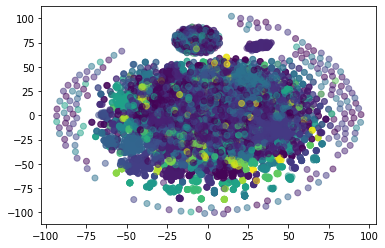

In [86]:
plt.scatter(emb_2d[:,0], emb_2d[:,1], alpha=0.5, c=cluster_df.cluster);

In [99]:
plot_df = pd.DataFrame(emb_2d, columns=['x', 'y'], index=sample_emb_df.index)

In [101]:
plot_df = plot_df.join(sample_df)

In [102]:
plot_df.head()

x          y pubId  \
11   0.651773  17.567633   290   
22   9.414875 -38.423042   290   
29  16.919762  55.170612   290   
33   9.918068  34.705666   290   
52 -31.839876  27.201897   290   

                                         canonicalUrl  \
11  zerohedge.com/news/2018-07-19/la-liberals-stag...   
22  zerohedge.com/news/2018-07-19/wells-fargo-has-...   
29  zerohedge.com/news/2018-07-19/white-house-aske...   
33  zerohedge.com/news/2018-07-18/wheres-panic-why...   
52  zerohedge.com/news/2018-07-19/maxine-waters-fe...   

                     firstScrape  \
11   7/19/2018 7:50:19 PM -04:00   
22  7/19/2018 11:53:37 AM -04:00   
29   7/20/2018 1:35:15 AM -04:00   
33   7/19/2018 8:26:52 AM -04:00   
52   7/19/2018 1:03:04 PM -04:00   

                                                title  \
11  LA Liberals Stage "Emergency Protest" At Koshe...   
22  Wells Fargo Caught In Yet Another Scandal | Ze...   
29  Asked 8 Times For Trump-Rouhani Meeting, Iran ...   
33  "Where’s The Panic": Why Trade War Hedges Aren...   
52  Maxine Waters Fears "Armed Protests" As Oath K...   

                                                 text lang_reliability  \
11  by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...                1   
22  by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...                1   
29  by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...                1   
33  by Knave Dave - Jul 18, 2018 1:11 pm ### This ...                1   
52  by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...                1   

   lang_iso  title_len  text_len        label  k_predict  cd_predict  
11       en         75      3317     helsinki         14           0  
22       en         54      5018     helsinki          5           1  
29       en         63      2701     helsinki         12           1  
33       en         69      3265     helsinki         19           1  
52       en         88      3952  cave_rescue         12           2

In [107]:
plot_df.label = plot_df.label.astype(str)

In [108]:
import plotly.express as px
fig = px.scatter(plot_df, x="x", y="y", color="label", hover_data=['canonicalUrl', 'title'])
fig.show()

In [111]:
fig = px.scatter(plot_df[plot_df.label != 'nan'], x="x", y="y", color="label", hover_data=['canonicalUrl', 'title'])
fig.update_layout(title='t-SNE Visualization of Article Doc2Vec with label')
fig.show()